# Naive Bayes

### 优缺点
- Pros：在数据较少的情况下仍然有效，可以处理多类别问题
- Cons：对于输入数据的准备方式较为敏感
- 适用数据类型：标称型数据

### 一般过程
- 数据处理
    - 收集数据：可以适用任何方法，如RSS源或爬虫等，也可以直接导入外部数据集或者自己杜撰
    - 准备数据：需要数值型或者bool型数据
    - 分析数据：有大量特征时，绘制特征作用不大， 此时使用直方图效果更好
- 算法模型
    - 训练算法：计算不同的独立特征的条件概率
    - 测试算法：计算错误率
- 结论
    - 使用算法：一个常见的朴素贝叶斯应用是文本分类，可以在任意的分类场景中使用朴素贝叶斯分类器，不一定非要是文本

In [17]:
#头文件
import numpy as np

## 数据处理

### 收集数据：通过杜撰来实现

In [1]:
def loadDataSet():
    #feature，语料集，其实就是对原始句子进行分词操作之后的词组
    postingList = [
        ['my', 'dog', 'has', 'flea', 'problems', 'help', 'please'],
        ['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid'],
        ['my', 'dalmation', 'is', 'so', 'cute', 'I', 'love', 'him'],
        ['stop', 'posting', 'stupid', 'worthless', 'garbage'],
        ['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him'],
        ['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']
    ]
    #label， 1: is abusive , 0: not abusive
    classVec = [0, 1, 0, 1, 0, 1]
    
    return postingList, classVec

### 准备数据：将词表转换到词向量

In [5]:
#构建词典
def createVocabList(dataSet):
    #创建一个空集合
    vocabSet = set([])      
    #对两个集合的元素求并集，来得到语料集中的词汇项集合
    for document in dataSet:      
        vocabSet = vocabSet | set(document)
    
    return list(vocabSet)

In [67]:
#将句子转化为对应词典的词向量矩阵（词袋模型 bag-of-words model）
def bagOfWords2Vec(vocabList, inputSet):
    #创建一个与词典同等长度的初始值为0的词向量矩阵
    returnVec = [0] * len(vocabList)
    for word in inputSet:
        if word in vocabList:
            returnVec[vocabList.index(word)] += 1
        else:
            print("The Word [%d] is not in my Vocabulary!" % word)
    
    return returnVec

### 分析数据

#### 观察使用 *createVocabList function* 转化后得到的词典

In [10]:
listOPosts, listClasses = loadDataSet()
myVocabList = createVocabList(listOPosts)
print(myVocabList)
print(len(myVocabList))

['take', 'stop', 'steak', 'ate', 'I', 'dog', 'posting', 'so', 'how', 'my', 'garbage', 'to', 'please', 'mr', 'is', 'buying', 'quit', 'flea', 'food', 'stupid', 'has', 'park', 'problems', 'dalmation', 'not', 'licks', 'maybe', 'help', 'cute', 'him', 'worthless', 'love']
32


#### 观察训练集中的 sample 通过  *bagOfWords2Vec function* 得到的词向量

In [28]:
bagOfWords2Vec

['my', 'dog', 'has', 'flea', 'problems', 'help', 'please']
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0] 

['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid']
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0] 

['my', 'dalmation', 'is', 'so', 'cute', 'I', 'love', 'him']
[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1] 

['stop', 'posting', 'stupid', 'worthless', 'garbage']
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 

['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him']
[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0] 

['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 



## 算法模型

### 训练算法

#### 公式说明
朴素贝叶斯的公式为：$p(c_i|\textbf{w})=\frac{p(\textbf{w}|c_i)p(c_i)}{p(\textbf{w})}$
- 先验概率 $p(c_i)$：类别 $i$（is abusive or not）中的文档数除以总文档数来得到
- 条件概率 $p(\textbf{w}|c_i)$ = $p(w_0,w_1,...,w_N|c_i)$ = $p(w_0|c_i)p(w_1|c_i)...p(w_N|c_i)$（若满足朴素贝叶斯的条件独立性假设）：计算对于每个类别c_i,w_0词条所占的数目占总词条数目的比例（$\textbf{w}$表示一个输入的完整的分词之后的词组矩阵，$w_i$表示一个词）

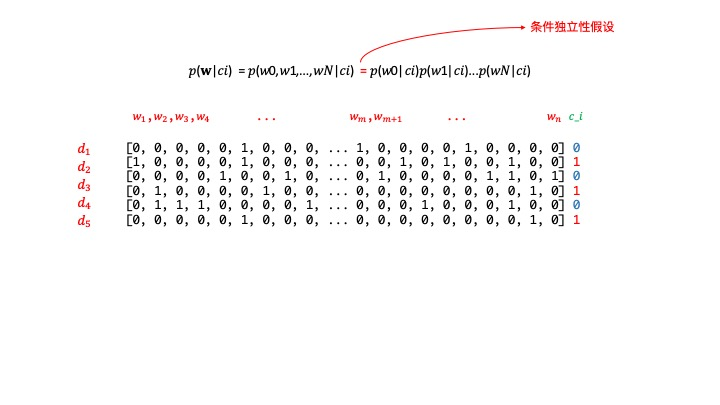

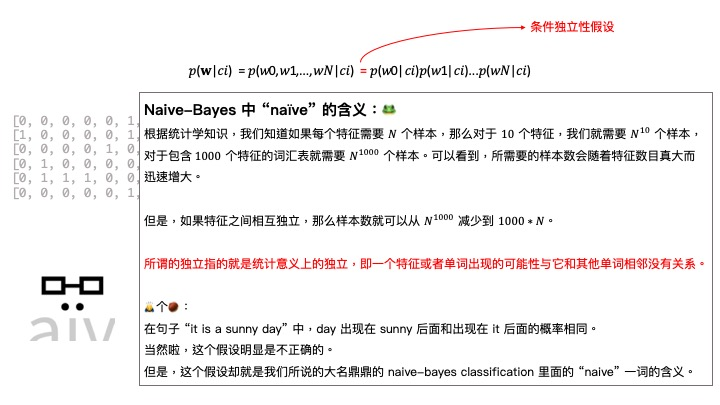

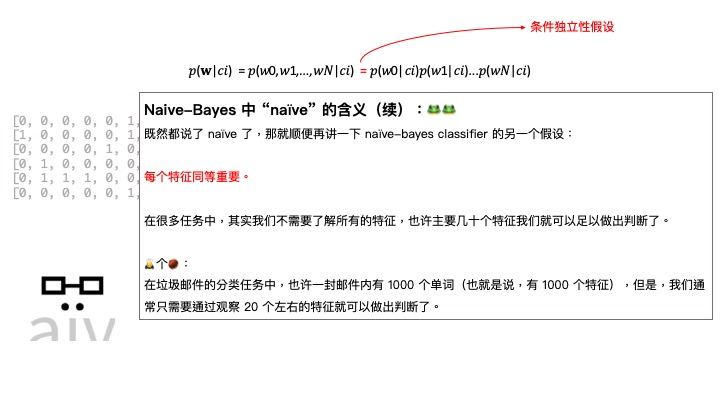

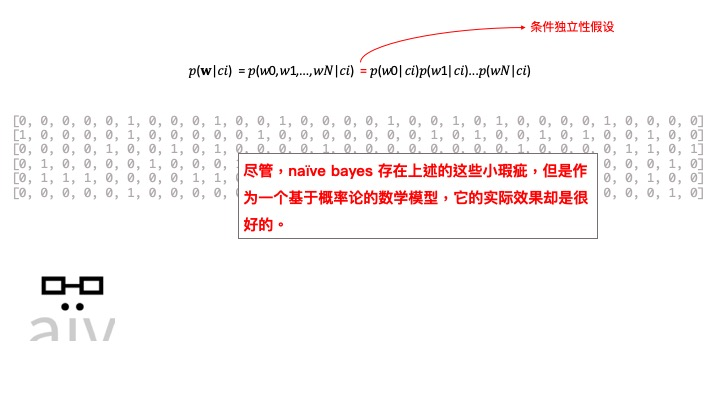

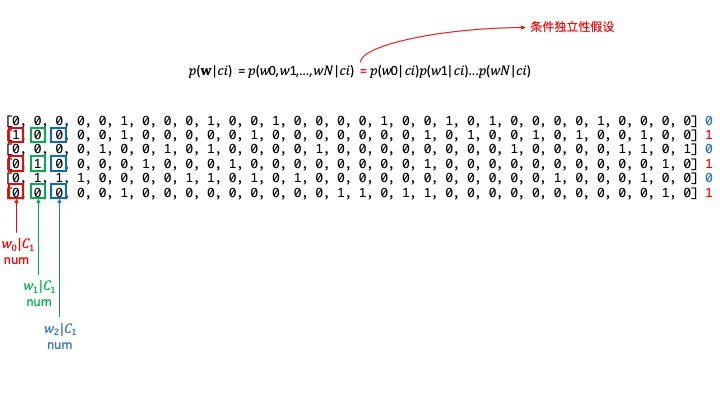

#### 公式的伪代码实现
```
计算每个类别中的文档数目
对于每篇文档：
    对每个类别：
        如果词条出现在文档中 -> 增加该词条的计数值
        增加所有词条的计数值
    对每个类别：
        对每个词条：
            将该词条的数目除以总词条数目得到条件概率
    
    返回每个类别的条件概率
```

In [69]:
def trainNB0(trainMatrix, trainCategory):    
    #文档数
    numTrainDocs = len(trainMatrix)
    #每个文档内的句子长度
    numWords = len(trainMatrix[0])
    
    #先验概率
    #label == 1的 abusive 类的先验概率，即 p(c1)
    #由于这是一个二分类问题，所以 p(c0) = 1 - p(c1) 
    pAbusive = sum(trainCategory) / numTrainDocs
    
    #条件概率
    #label == 0 & label == 1的 conditional probability，即 p(wi|c0) 和 p(wi|c1)
    #需要初始化程序中的分子和分母变量。
    #一旦某个词语（is abusive or not）在某一个 document 中出现，则该词对应的个数（p1Num or p0Num）就 +1，
    #而且，在所有文档中，该文档的总词数也相应 +1
    #使用拉普拉斯平滑
    p0Num = np.ones(numWords)
    p1Num = np.ones(numWords)
    p0Denom = 2.0 
    p1Denom = 2.0   
    for i in range(numTrainDocs):
        #label == 1
        if trainCategory[i] == 1:
            p1Num += trainMatrix[i]          #向量相加
            p1Denom += sum(trainMatrix[i])   #该文档中所有label==1的数量
        else:
            p0Num += trainMatrix[i]          #向量相加
            p0Denom += sum(trainMatrix[i])
    
    print("p0Num:\n", p0Num)
    print("p0Denom:\n", p0Denom)
    print("\np1Num:\n", p1Num)
    print("p1Denom:\n", p1Denom)
    print("\n-----------------------------------------------\n")
    
    #对每个元素做除法，计算概率
    #由于 p(wi|ci) 可能都较小，如果将他们相乘，可能会出现负溢出的现象，所以通过取 log 来避免有负溢出可能导致的问题。
    p1Vect = np.log(p1Num/p1Denom)              #p(W|c1)  
    p0Vect = np.log(p0Num/p0Denom)              #p(W|c0)
    
    return p0Vect, p1Vect, pAbusive

#### 使用准备好的训练集数据进行训练

In [70]:
listOPosts, listClasses = loadDataSet()
myVocabList = createVocabList(listOPosts)
#将训练集语料全部转化为训练集词向量矩阵
trainMat = []
for postinDoc in listOPosts:
    trainMat.append(bagOfWords2Vec(myVocabList, postinDoc))
#使用朴素贝叶斯计算条件概率和先验概率
p0V, p1V, pAb = trainNB0(trainMat, listClasses)
print("p0V:\n", p0V)
print("p1V:\n", p1V)
print("pAb:\n", pAb)

p0Num:
 [1. 2. 2. 2. 2. 2. 1. 2. 2. 4. 1. 2. 2. 2. 2. 1. 1. 2. 1. 1. 2. 1. 2. 2.
 1. 2. 1. 2. 2. 3. 1. 2.]
p0Denom:
 26.0

p1Num:
 [2. 2. 1. 1. 1. 3. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 2. 1. 2. 4. 1. 2. 1. 1.
 2. 1. 2. 1. 1. 2. 3. 1.]
p1Denom:
 21.0

-----------------------------------------------

p0V:
 [-3.25809654 -2.56494936 -2.56494936 -2.56494936 -2.56494936 -2.56494936
 -3.25809654 -2.56494936 -2.56494936 -1.87180218 -3.25809654 -2.56494936
 -2.56494936 -2.56494936 -2.56494936 -3.25809654 -3.25809654 -2.56494936
 -3.25809654 -3.25809654 -2.56494936 -3.25809654 -2.56494936 -2.56494936
 -3.25809654 -2.56494936 -3.25809654 -2.56494936 -2.56494936 -2.15948425
 -3.25809654 -2.56494936]
p1V:
 [-2.35137526 -2.35137526 -3.04452244 -3.04452244 -3.04452244 -1.94591015
 -2.35137526 -3.04452244 -3.04452244 -3.04452244 -2.35137526 -2.35137526
 -3.04452244 -3.04452244 -3.04452244 -2.35137526 -2.35137526 -3.04452244
 -2.35137526 -1.65822808 -3.04452244 -2.35137526 -3.04452244 -3.04452244
 -2.351375

#### 检查训练集的训练结果是否正确

In [57]:
for i in range(6):
    if(listClasses[i] == 0):
        print(trainMat[i], "\n")

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0] 

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1] 

[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0] 



在前面的训练中，我们输出了 p0Num 和 p0Demon 的值，为：
```
p0Num:
 [1. 2. 2. 2. 2. 2. 1. 2. 2. 4. 1. 2. 2. 2. 2. 1. 1. 2. 1. 1. 2. 1. 2. 2.
 1. 2. 1. 2. 2. 3. 1. 2.]
p0Denom:
 26.0
```
通过手动人眼鉴别，与训练集的真实词向量输入对比，发现没有错误。（⚠️ 这里我们使用了拉普拉斯平滑，所以分子需要+1，分母需要+2）

### 测试算法

#### 实现朴素贝叶斯分类器

在前面，我们已经通过训练集计算出了朴素贝叶斯的先验概率和条件概率。

我们需要使用这两个计算出来的概率值来计算当我们的 $\textbf{w}$ 选取为新的测试集的词向量矩阵 $\textbf{new_w}$ 时的后验概率 $p(c_i|\textbf{new_w})$。同时比较，$p(c_0|\textbf{new_w})$ 和 $p(c_1|\textbf{new_w})$ 的值哪个更大，比较返回大概率对应的标签，作为我们的分类器的预测结果。

⚠️ 在使用 *trainNB0 function* 计算概率的时候，我们使用了取 log 代替了分数，这样对于原式 $p(\textbf{w}|c_i)$ = $p(w_0,w_1,...,w_N|c_i)$ = $p(w_0|c_i)p(w_1|c_i)...p(w_N|c_i)$，就变成了 $log(p(w_0|c_i)) + log(p(w_1|c_i)) + ... + log(p(w_N|c_i))$

In [62]:
def classifyNB(vec2Classify, p0Vec, p1Vec, pClass1):
    #取log，将条件概率与先验概率之间的乘法操作，变成了加法操作
    #另外，我们需要在 c_i 取 c1 和 c0 时，
    #分别通过贝叶斯公式来计算此时的后验概率。
    p1 = sum(vec2Classify * p1Vec) + np.log(pClass1)    
    p0 = sum(vec2Classify * p0Vec) + np.log(1.0 - pClass1)
    #比较选择大概率结果，返回
    if p1 > p0:
        return 1
    else: 
        return 0

### 使用测试集数据进行测试

In [63]:
listOPosts, listClasses = loadDataSet()
myVocabList = createVocabList(listOPosts)
#将训练集语料全部转化为训练集词向量矩阵
trainMat = []
for postinDoc in listOPosts:
    trainMat.append(bagOfWords2Vec(myVocabList, postinDoc))
#使用朴素贝叶斯计算条件概率和先验概率
p0V, p1V, pAb = trainNB0(trainMat, listClasses)
print("p0V:\n", p0V)
print("p1V:\n", p1V)
print("pAb:\n", pAb)

p0Num:
 [1. 2. 2. 2. 2. 2. 1. 2. 2. 4. 1. 2. 2. 2. 2. 1. 1. 2. 1. 1. 2. 1. 2. 2.
 1. 2. 1. 2. 2. 3. 1. 2.]
p0Denom:
 26.0

p1Num:
 [2. 2. 1. 1. 1. 3. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 2. 1. 2. 4. 1. 2. 1. 1.
 2. 1. 2. 1. 1. 2. 3. 1.]
p1Denom:
 21.0

-----------------------------------------------

p0V:
 [-3.25809654 -2.56494936 -2.56494936 -2.56494936 -2.56494936 -2.56494936
 -3.25809654 -2.56494936 -2.56494936 -1.87180218 -3.25809654 -2.56494936
 -2.56494936 -2.56494936 -2.56494936 -3.25809654 -3.25809654 -2.56494936
 -3.25809654 -3.25809654 -2.56494936 -3.25809654 -2.56494936 -2.56494936
 -3.25809654 -2.56494936 -3.25809654 -2.56494936 -2.56494936 -2.15948425
 -3.25809654 -2.56494936]
p1V:
 [-2.35137526 -2.35137526 -3.04452244 -3.04452244 -3.04452244 -1.94591015
 -2.35137526 -3.04452244 -3.04452244 -3.04452244 -2.35137526 -2.35137526
 -3.04452244 -3.04452244 -3.04452244 -2.35137526 -2.35137526 -3.04452244
 -2.35137526 -1.65822808 -3.04452244 -2.35137526 -3.04452244 -3.04452244
 -2.351375

In [64]:
testEntry = ['love', 'my', 'dalmation']
thisDoc = np.array(bagOfWords2Vec(myVocabList, testEntry))
print(testEntry,'classified as: ',classifyNB(thisDoc,p0V,p1V,pAb))
print()
testEntry = ['stupid', 'garbage']
thisDoc = np.array(bagOfWords2Vec(myVocabList, testEntry))
print(testEntry,'classified as: ',classifyNB(thisDoc,p0V,p1V,pAb))

['love', 'my', 'dalmation'] classified as:  0

['stupid', 'garbage'] classified as:  1
